# Data Analysis

In this file, we proceed to develop and test the pipeline that handles our dataset.

We then proceed to analyse the output of said pipeline later on

### All the imports for all the things

In [3]:
import os
import sys
import pandas as pd
import datetime


import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  






import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

# for translation of gene symbols
import mygene

import pathlib
import scipy

from sklearn.preprocessing import normalize, MinMaxScaler

# to import libs 
sys.path.append('../src/utils')
import feature_selection, visualisation




# datasets

# default path of the folder containing the salmon files
absolute_path = '/Users/aygalic/Thesis/data/quant/'  
metadata_path = '/Users/aygalic/Thesis/METADATA_200123.xlsx'  


mg = mygene.MyGeneInfo()

# Helper function definition

This functions offload a bit of complexity out of the main function for data handling and are just helpers.

In [4]:
# from filename to tensor
# here we open a single file passed as "filename" we return a tensor of TPM values.
def load_patient_data(filename, path = absolute_path):
  #specify read types for our data
  read_types = [float()]
  # get a first sample to base everything of
  text = pathlib.Path(os.path.join(path,filename)).read_text()
  lines = text.split('\n')[1:-1]
  # the 3rd column correspond to TPM values.
  features = tf.io.decode_csv(lines, record_defaults=read_types, field_delim = "\t", select_cols=[3])
  data = tf.convert_to_tensor(features)[0]
  return data

In [35]:
# here we open a single file passed as "filename" we return a lit of the values names.
def get_names(filename, path = absolute_path):
    names = pd.read_csv(os.path.join(path,filename), sep='\t')
    return [n for n in names.Name]


### Some testing about gene name retrieval

In [4]:
# each couple of entries correspond to one patient, we are only interested in the "transcript" files
entries = os.listdir(absolute_path)
#entries_transcripts = [e for e in entries if "transcripts" in e ]
entries = [e for e in entries if "genes" in e ]
entry = entries[0]
entry

'PPMI-Phase2-IR2.56706.BL.0003397555.5104-SL-4062.longRNA-NEBKAP.salmon-gtf.genes.sf'

In [5]:
names = get_names(entry)
names[1:5]

['ENSG00000215515', 'ENSG00000215399', 'ENSG00000196331', 'ENSG00000206044']

In [6]:
symbols = mg.querymany(names, fields = ['genomic_pos', 'symbol'], scopes='ensembl.gene', species='human', verbose = False, as_dataframe = True)
symbols

,_id,_score,symbol,genomic_pos.chr,genomic_pos.end,genomic_pos.ensemblgene,genomic_pos.start,genomic_pos.strand,notfound,genomic_pos
query,,,,,,,,,,
ENSG00000198900,7150,26.219004,TOP1,20,41124487.0,ENSG00000198900,41028822.0,1.0,NaN,NaN
ENSG00000215515,ENSG00000215515,8.460784,IFIT1P1,13,32386108.0,ENSG00000215515,32384660.0,1.0,NaN,NaN
ENSG00000215399,ENSG00000215399,8.457741,HMGB3P7,13,101802488.0,ENSG00000215399,101801878.0,1.0,NaN,NaN
ENSG00000196331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
ENSG00000206044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
...,...,...,...,...,...,...,...,...,...,...
ENSG00000187210,2650,26.217218,GCNT1,9,76651203.0,ENSG00000187210,76419850.0,1.0,NaN,NaN
ENSG00000263426,106481051,8.457168,RN7SL471P,6,28977773.0,ENSG00000263426,28977475.0,1.0,NaN,NaN
ENSG00000264729,ENSG00000264729,26.228430,NaN,17,16805707.0,ENSG00000264729,16804627.0,1.0,NaN,NaN


In [7]:
symbols = symbols.reset_index()
symbols = symbols.drop_duplicates(subset = ["query"])

In [8]:
# WE HAVE NO SYMBOLS THAT START WITH ENSG
[s for s in symbols["symbol"].fillna("") if s.startswith('ENSG') ]


[]

In [9]:
sorted_sym = symbols.sort_values(['genomic_pos.chr', 'genomic_pos.start'], ascending=[True, True])

In [10]:
sorted_values = sorted_sym[['genomic_pos.chr', 'genomic_pos.start']].values
sorted_values

array([['1', 12010.0],
       ['1', 14404.0],
       ['1', 34554.0],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=object)

# Main function definition for the "genes" dataset

This is the main function that does the heavy lifting.

It has a lot of parametter to allow the user to process its dataset in many different ways.

The processing is four-fold : 

## Cell selection

Here we can decide to keep observations based on the provided meta-data.

## Feature engineering/sorting

Here we select genes based on criterions, we can also sort them based on their positions on the genome.

## Rescaling

Here we proceed to standardise or logscale the data

## Formating

Here the user can decide to output the dataset cellwise, or patient wise as time series.

In [30]:
### now we design a function that return a dataset of multivriate time series or the individual timestamps
def generate_dataset(path = absolute_path, 
                     metadata_path = metadata_path,
                     feature_selection_threshold = None, 
                     batch_size = 64, 
                     subsample = None, 
                     retain_phases = None,
                     feature_selection_proceedure = None,
                     sgdc_params = None,
                     class_balancing = None,
                     normalization = True,
                     minimum_time_point = "BL",
                     as_time_series = False,
                     transpose = False,
                     dataset_of_interest = "genes",
                     MT_removal = True,
                     log1p = True,
                     min_max = True,
                     keep_only_symbols = False,
                     drop_ambiguous_pos = False,
                     sort_symbols = False):

    if(dataset_of_interest not in ["genes", "transcripts"]):
        print("err, 'dataset_of_interest' must be either 'genes' or 'transcripts'")
        return
    # getting entries ready
    # each couple of entries correspond to one patient, we are only interested in the "transcript" files
    entries = os.listdir(path)
    #entries_transcripts = [e for e in entries if "transcripts" in e ]
    entries = [e for e in entries if dataset_of_interest in e ]
    
    # we load metadata, so we can have access to additional information not included in the filename
    meta_data = pd.read_excel(metadata_path, header = 1, usecols = range(1,10) )

    ###########################################
    ###### pre-loading patient selection ######
    ###########################################
    # selecting which entires to include in our analysis

    # To avoid the natural tendency of the model to base its response to different phases
    # we provide the option to focus our analysis on either or both phases of the study.
    

    if(retain_phases == "1"):
        entries = [e for e in entries if "Phase1" in e ]
        print("retained phase 1")
    elif(retain_phases == "2"):
        entries = [e for e in entries if "Phase2" in e ]
        print("retained phase 2")
    elif(retain_phases == "Both"):
        print("Retaining patients that are included in phases 1 & 2")
        phase_1_ids = [p.split(".")[1] for p in  entries if "Phase1" in p]
        phase_2_ids = [p.split(".")[1] for p in  entries if "Phase2" in p]
        # Find the entries that match with both Phase 1 and Phase 2
        common_ids = set(phase_1_ids) & set(phase_2_ids) # set intersection
        entries_matching_both_phases = [entry for entry in entries if any(f".{common_id}." in entry for common_id in common_ids)]
        entries = entries_matching_both_phases
    elif(retain_phases == None):
        print("not applying any filtering over phases")
    else:
        print("Warning: 'retain_phases' argment wrong.") # couldn't use warning due to conflicts


    # if we want a smaller dataset for testing purposes
    if(subsample is not None):
        entries = entries[0:subsample]

    # We can decide to only include patient who completed a given quantities of timepoints
    # The following stategy for filtering also filters out every patient who have missed a visit up to the given timepoint.
    # This comportement could be tweaked easely later on
    # a bit clunky though
    if(minimum_time_point == "BL" and as_time_series == False):
        print("retaining all patient who have at least passed the Base Line Visit...")
        BL_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "BL"] 
        matchin_entries = [entry for entry in entries if entry.split(".")[1] in BL_ids]
        entries = matchin_entries
    elif(minimum_time_point == "V02" and as_time_series == False):
        print("retaining all patient who have at least passed the Base Line to month 6 Visit...")
        BL_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "BL"] 
        V02_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V02"] 
        common_ids = set(BL_ids) & set(V02_ids) 
        matchin_entries = [entry for entry in entries if entry.split(".")[1] in common_ids]
        entries = matchin_entries
    elif(minimum_time_point == "V04" and as_time_series == False):
        print("retaining all patient who have at least passed the Base Line to month 12 Visit...")
        BL_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "BL"] 
        V02_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V02"] 
        V04_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V04"] 
        common_ids = set(BL_ids) & set(V02_ids) & set(V04_ids) 
        matchin_entries = [entry for entry in entries if entry.split(".")[1] in common_ids]
        entries = matchin_entries
    elif(minimum_time_point == "V06" and as_time_series == False):
        print("retaining all patient who have at least passed the Base Line to month 24 Visit...")
        BL_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "BL"] 
        V02_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V02"] 
        V04_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V04"] 
        V06_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V06"] 
        common_ids = set(BL_ids) & set(V02_ids) & set(V04_ids) & set(V06_ids) 
        matchin_entries = [entry for entry in entries if entry.split(".")[1] in common_ids]
        entries = matchin_entries
    
    # if we want time series, we constrain them to only patients that went through every visits.
    elif(minimum_time_point == "V08" or as_time_series == True):
        print("retaining all patient who have passed all visits...")
        BL_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "BL"] 
        V02_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V02"] 
        V04_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V04"] 
        V06_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V06"] 
        V08_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V08"] 
        common_ids = set(BL_ids) & set(V02_ids) & set(V04_ids) & set(V06_ids) & set(V08_ids) 
        matchin_entries = [entry for entry in entries if entry.split(".")[1] in common_ids]
        entries = matchin_entries




    # sanity check : are the patient numbers actually numeric ? 
    entries = [e for e in entries if e.split(".")[1].isnumeric() ]

    # sanity check : don't load patient where some values are missing
    Na_s =  meta_data[meta_data.isna().any(axis=1)]["Patient Number"]
    entries = [e for e in entries if e.split(".")[1] not in str(Na_s) ]

    ###########################################
    ############ loading patients  ############
    ###########################################

    # load the dataset into an array 
    print("loading samples...")
    data = [load_patient_data(e, path) for e in entries]

    # get the entry name list
    names = get_names(entries[0], path)
    # getting rid of the version number
    names = [n.split(".")[0] for n in names]
    
    # remove artifacts by keeping samples of correct length
    if(dataset_of_interest == "transcprits"):
        samples_to_keep = [1 if s.shape == (95309) else 0 for s in data]
    elif(dataset_of_interest == "genes"):
        samples_to_keep = [1 if s.shape == (34569) else 0 for s in data]
        
    print("loaded",len(samples_to_keep), "samples")
    
    train_ds = [sample for (sample, test) in  zip(data, samples_to_keep) if test]
    data_array = np.array(train_ds)

    patient_id = [int(p.split(".")[1]) for (p, test) in  zip(entries, samples_to_keep) if test]

    # only keep metadata for selected patients
    meta_data = meta_data.set_index('Patient Number')
    meta_data = meta_data.reindex(index=patient_id)
    meta_data = meta_data.reset_index()





    ###########################################
    ############ feature selection  ###########
    ###########################################
    
    print("retriving symbols for genes")
    query_result = mg.querymany(names, fields = ['genomic_pos', 'symbol'], scopes='ensembl.gene', species='human', verbose = False, as_dataframe = True)

    query_result = query_result.reset_index()
    query_result = query_result.drop_duplicates(subset = ["query"])
    # here we have the correct length

    names = [q if(pd.isna(s)) else s for (s,q) in zip(query_result["symbol"],query_result["query"])]
    query_result['name'] = names

    if(MT_removal == True):
        gene_selected = [False if q.startswith('MT') else True for q in query_result['name']]
        print("removing", len(gene_selected) - sum(gene_selected), "mithocondrial genes from the dataset")
        data_array = data_array[:,gene_selected]
        query_result = query_result[gene_selected]

    if(keep_only_symbols == True):
        gene_selected = [False if s.startswith('ENSG') else True for s in query_result['name']]
        print("removing", len(gene_selected) - sum(gene_selected), "not found symbols from the dataset")
        data_array = data_array[:,gene_selected]
        query_result = query_result[gene_selected]

    if(drop_ambiguous_pos == True):
        gene_selected = query_result["genomic_pos"].isna()
        print("removing", len(gene_selected) - sum(gene_selected), "ambigously positioned symbols from the dataset")
        data_array = data_array[:,gene_selected]
        query_result = query_result[gene_selected]

    if(feature_selection_threshold is not None):
        print("selecting genes based on median absolute deviation threshold: ",feature_selection_threshold, "...")
        gene_selected = feature_selection.MAD_selection(data_array, feature_selection_threshold)
        print("removing", len(gene_selected) - sum(gene_selected), "genes under the MAD threshold from the dataset")
        data_array = data_array[:,gene_selected]
        query_result = query_result[gene_selected]

    if(feature_selection_proceedure == "LASSO"):
        # for each patient in our dataset, we want to know to what cohort he belongs
        cohorts = np.array(meta_data["Cohort"], dtype=np.int32)
        print("selecting genes based on LASSO-like classification...")
        gene_selected = feature_selection.LASSO_selection(data_array, cohorts, sgdc_params, class_balancing)
        data_array = data_array[:,gene_selected]
        query_result = query_result[gene_selected]



    print("number of genes selected : ", len(data_array[0]))


    ###########################################
    ################# sorting  ################
    ###########################################
    if(sort_symbols):
        print("sorting based on genomic position chr then transcript start...")
        # reset the indexes because of all the previous transformations we have done
        query_result = query_result.reset_index(drop=True)
        query_result = query_result.sort_values(['genomic_pos.chr', 'genomic_pos.start'], ascending=[True, True])
        # Extract the sorted rows as a NumPy array
        data_array = data_array[:, query_result.index]


    ###########################################
    ############## normalisation  #############
    ###########################################

    
    if(normalization == True): 
        print("normalizing data...")
        data_array = normalize(data_array)

    if(log1p == True): 
        print("log(1 + x) transformation...")
        data_array = np.log1p(data_array)

    # after log1p transform because it already provide us with a very good dataset 
    if(min_max == True):
        print("scaling to [0, 1]...")
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_array = scaler.fit_transform(data_array)


    ##########################################
    ######## Building the time series ########
    ##########################################
    print("number of seq in the dataset :", len(data_array))

    if(as_time_series == True):
        print("converting samples to time series")
        big_bad_dict = {key: [sample for (sample, name) in zip(data_array, entries) if int(name.split(".")[1]) == key] for key in patient_id}

        print("number of actual individual to be studied :", len(big_bad_dict))

        # Convert dictionary values to numpy arrays
        sequences = np.array(list(big_bad_dict.values()), dtype=np.float32)

        # Step 2: Create a TensorFlow Dataset
        x_train = tf.data.Dataset.from_tensor_slices(sequences)

        if(transpose):
            print("using transposed data...")

            # Define a function to transpose a sequence
            def transpose_sequence(sequence):
                return tf.transpose(sequence, perm=[1, 0])

            # Transpose each element in the dataset
            x_train = x_train.map(transpose_sequence)


        # to keep track of which timeserie correspond to which identifier
        sequence_names = list(big_bad_dict.keys())
    else:
        # we don't assemble the files into timeseries and simply return the TPM values and the corresponding filename
        print("keeping sample as is, no conversion to time series")
        x_train = tf.data.Dataset.from_tensor_slices(data_array)
        sequence_names = [f for (f, test) in  zip(entries, samples_to_keep) if test]

    # make it a batched dataset
    dataset = x_train.batch(batch_size)

    
    return dataset, sequence_names, len(data_array[0]), query_result





### Just a bit of testing 

Retaining patients that are included in phases 1 & 2
retaining all patient who have passed all visits...
loading samples...
loaded 1455 samples
retriving symbols for genes
selecting genes based on median absolute deviation threshold:  2 ...
0.0
4884.701


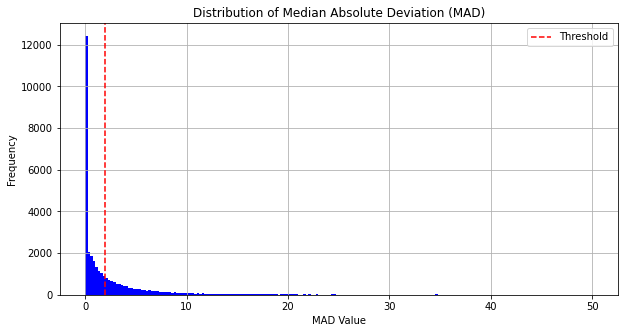

removing 22612 genes under the MAD threshold from the dataset
number of genes selected :  11957
log(1 + x) transformation...
scaling to [-1, 1]...
number of seq in the dataset : 1455
converting samples to time series
number of actual individual to be studied : 291


In [31]:
importlib.reload(feature_selection) # to allow modification of the script without restarting the whole session


as_time_series = True
dataset, index_names, n_genes, gene_names = generate_dataset(feature_selection_threshold = 2, 
                                                            batch_size = 32, 
                                                            retain_phases = "Both",
                                                            normalization = False,
                                                            as_time_series = as_time_series,
                                                            MT_removal = False)


get the dataset as a numpy object for data manipulation

In [32]:
# get everything out of TensorFlow back to numpy/pandas
data = np.concatenate(list(dataset.as_numpy_iterator()), axis=0)
if(as_time_series):
    data = data.reshape(data.shape[0]*data.shape[1], -1)
    data = pd.DataFrame(data)
    data.columns = gene_names["name"]
    data.index = np.repeat(index_names, 5, axis=0)
else:
    data = pd.DataFrame(data)
    data.columns = gene_names["name"]
    data.index = index_names


In [33]:
print(data.head())

name      TOP1  ENSGR0000168939  ENSGR0000214717  ENSGR0000182484   
3442  0.314952         0.360238         0.136580         0.517728  \
3442  0.314498         0.420334         0.281522         0.490566   
3442  0.742467         0.354860         0.261963         0.379775   
3442  0.563241         0.467921         0.193135         0.520309   
3442  0.344854         0.334907         0.132422         0.420329   

name  ENSGR0000198223  ENSGR0000185960  ENSGR0000205755  ENSGR0000185291   
3442        -0.384073        -0.030902         0.462116         0.471284  \
3442        -0.136599         0.229172         0.495155         0.485320   
3442        -0.313197         0.386343         0.304953         0.417484   
3442        -0.159063        -0.018419         0.390361         0.396865   
3442        -0.456131        -0.360034         0.325078         0.271394   

name  ENSGR0000002586     KIF5A  ...    GARRE1    PTMAP2    TSEN34     MAPK4   
3442        -0.187010  0.360238  ...  0.179150  

# Visualisation of the processing pipeline

In [54]:
# preparing the array of input parametter to be tested
# we incrementally add processing steps 

param_sets = [
    {   # vanilla dataset without much processing
        "feature_selection_threshold" : None, 
        "normalization" : False, 
        "MT_removal" : False, 
        "log1p" : False},

    {   # adding log1p transform
        "feature_selection_threshold" : None, 
        "normalization" : False, 
        "MT_removal" : False, 
        "log1p" : True},

    {   # adding MT removal
        "feature_selection_threshold" : None, 
        "normalization" : False, 
        "MT_removal" : True, 
        "log1p" : True},

    {   # keeping only symbols that can be ordered on the dataset and sorting the whole thing
        "feature_selection_threshold" : None, 
        "normalization" : False, 
        "MT_removal" : True, 
        "log1p" : True, 
        "keep_only_symbols" : True,
        "drop_ambiguous_pos" : True,
        "sort_symbols" : True}
    
    ]

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
retriving symbols for genes
number of genes selected :  34569
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


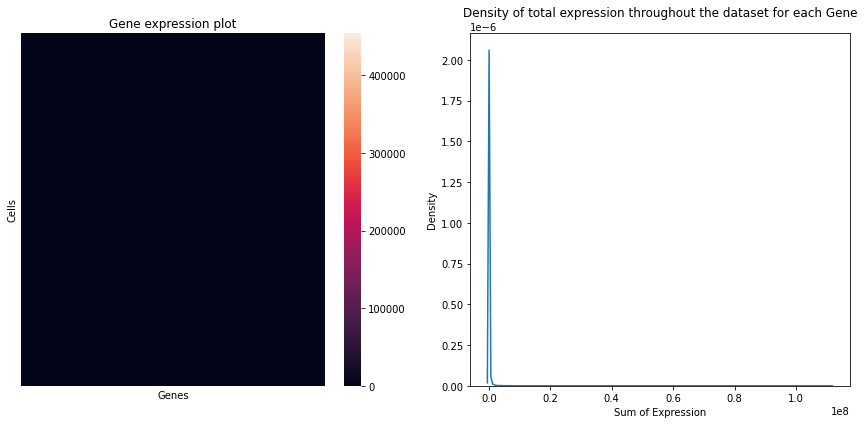

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
retriving symbols for genes
number of genes selected :  34569
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


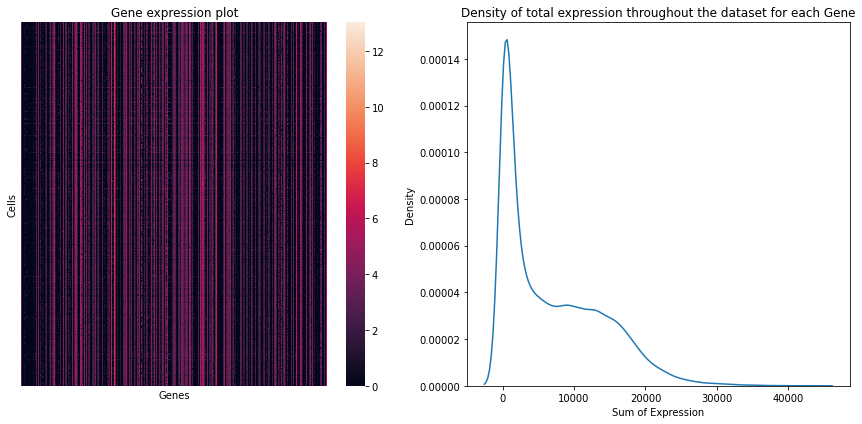

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
retriving symbols for genes
removing 298 mithocondrial genes from the dataset
number of genes selected :  34271
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


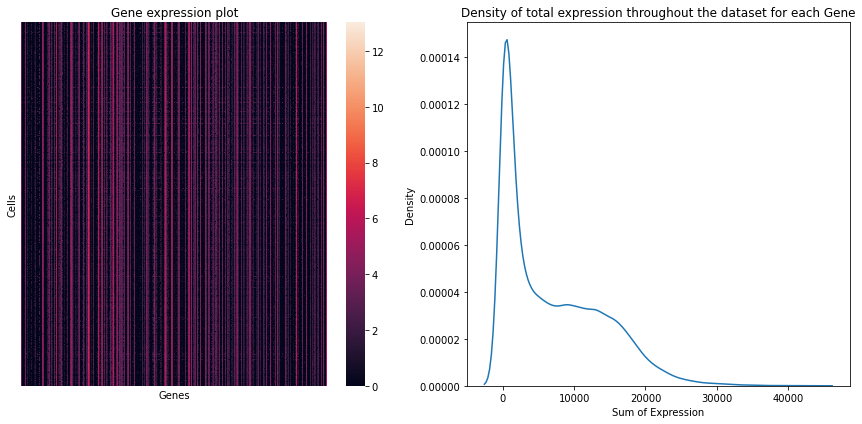

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
retriving symbols for genes
removing 298 mithocondrial genes from the dataset
removing 6748 not found symbols from the dataset
removing 1506 ambigously positioned symbols from the dataset
number of genes selected :  26017
sorting...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


: 

: 

In [63]:
for params in param_sets:
    dataset, index_names, n_genes, gene_names = generate_dataset(**params)
    data = np.concatenate(list(dataset.as_numpy_iterator()), axis=0)
    data = pd.DataFrame(data)
    data.columns = gene_names["name"]
    data.index = index_names
    visualisation.dataset_plot(data)



# Exemple pipeline with scprep

In [9]:
import scprep


In [10]:
# Remove empty columns and rows
data = scprep.filter.remove_empty_cells(data)
data = scprep.filter.remove_empty_genes(data)

/Users/aygalic/.local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: xlabel='Library size', ylabel='Number of cells'>

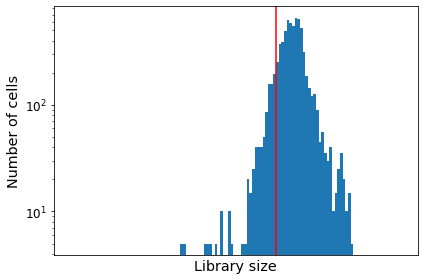

In [11]:
# Filter by library size to remove background
scprep.plot.plot_library_size(data, cutoff=50000)

In [12]:
data = scprep.filter.filter_library_size(data, cutoff=50000)

In [14]:
# not enough RAM to run

# Filter by mitochondrial expression to remove dead cells
#mt_genes = scprep.select.get_gene_set(data, starts_with="MT")
#scprep.plot.plot_gene_set_expression(data, genes=mt_genes, percentile=90)


#data = scprep.filter.filter_gene_set_expression(data, genes=mt_genes, percentile=90)


: 

: 

In [13]:
# Library size normalize
data_norm = scprep.normalize.library_size_normalize(data)
# Square root transform
data_sqrt = scprep.transform.sqrt(data_norm)

: 

: 

# Viz Viz


In [20]:
log_plus_one_df = np.log1p(df)

In [19]:
fig1 = go.Figure(go.Heatmap(z=log_plus_one_df, colorscale='viridis'))


In [23]:
fig1.write_html("../img/log_plus_one.html")


In [27]:
import seaborn as sns

In [35]:
#!pip install fastcluster # that thing made it actually slower
#!pip uninstall fastcluster 


Found existing installation: fastcluster 1.2.6
Uninstalling fastcluster-1.2.6:
  Would remove:
    /opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/_fastcluster.cpython-39-darwin.so
    /opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/fastcluster-1.2.6.dist-info/*
    /opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/fastcluster.py
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
zsh:1: command not found: Y


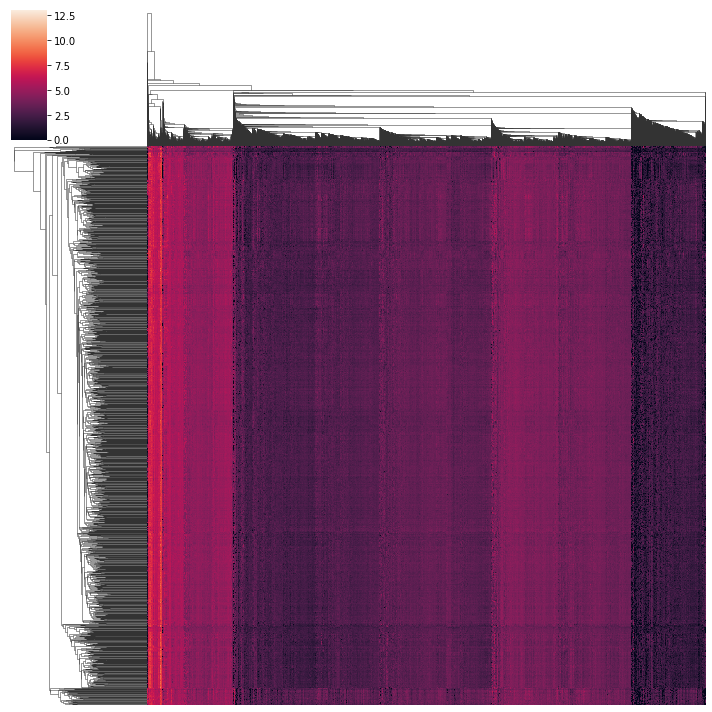

In [49]:
#cluster_plot = sns.clustermap(log_plus_one_df,yticklabels=False,xticklabels=False)
cluster_plot = sns.clustermap(log_plus_one_df,yticklabels=False,xticklabels=False)
cluster_plot

In [50]:
fig = cluster_plot.fig
fig.savefig("../img/seaborn_plot.jpg", dpi=300)

In [1]:
# Now designing the pipeline for the transcripts dataset

In [38]:
### now we design a function that return a dataset of multivriate time series or the individual timestamps

def generate_dataset_transcripts(path = absolute_path, 
                     metadata_path = metadata_path,
                     feature_selection_threshold = None, 
                     batch_size = 64, 
                     subsample = None, 
                     retain_phases = None,
                     feature_selection_proceedure = None,
                     sgdc_params = None,
                     class_balancing = None,
                     normalization = True,
                     minimum_time_point = "BL",
                     as_time_series = False,
                     transpose = False,
                     dataset_of_interest = "transcripts",
                     MT_removal = True,
                     log1p = True,
                     min_max = True,
                     keep_only_symbols = False,
                     drop_ambiguous_pos = False,
                     sort_symbols = False):

    if(dataset_of_interest not in ["genes", "transcripts"]):
        print("err, 'dataset_of_interest' must be either 'genes' or 'transcripts'")
        return
    # getting entries ready
    # each couple of entries correspond to one patient, we are only interested in the "transcript" files
    entries = os.listdir(path)
    #entries_transcripts = [e for e in entries if "transcripts" in e ]
    entries = [e for e in entries if dataset_of_interest in e ]
    # we load metadata, so we can have access to additional information not included in the filename
    meta_data = pd.read_excel(metadata_path, header = 1, usecols = range(1,10) )

    ###########################################
    ###### pre-loading patient selection ######
    ###########################################
    # selecting which entires to include in our analysis

    # To avoid the natural tendency of the model to base its response to different phases
    # we provide the option to focus our analysis on either or both phases of the study.
    

    if(retain_phases == "1"):
        entries = [e for e in entries if "Phase1" in e ]
        print("retained phase 1")
    elif(retain_phases == "2"):
        entries = [e for e in entries if "Phase2" in e ]
        print("retained phase 2")
    elif(retain_phases == "Both"):
        print("Retaining patients that are included in phases 1 & 2")
        phase_1_ids = [p.split(".")[1] for p in  entries if "Phase1" in p]
        phase_2_ids = [p.split(".")[1] for p in  entries if "Phase2" in p]
        # Find the entries that match with both Phase 1 and Phase 2
        common_ids = set(phase_1_ids) & set(phase_2_ids) # set intersection
        entries_matching_both_phases = [entry for entry in entries if any(f".{common_id}." in entry for common_id in common_ids)]
        entries = entries_matching_both_phases
    elif(retain_phases == None):
        print("not applying any filtering over phases")
    else:
        print("Warning: 'retain_phases' argment wrong.") # couldn't use warning due to conflicts



    # if we want a smaller dataset for testing purposes
    if(subsample is not None):
        entries = entries[0:subsample]


    # We can decide to only include patient who completed a given quantities of timepoints
    # The following stategy for filtering also filters out every patient who have missed a visit up to the given timepoint.
    # This comportement could be tweaked easely later on
    # a bit clunky though



    ########################################################################################
    # there is a bit of trouble shooting left to do in this section, in the case time series + BL
    ########################################################################################
    if(minimum_time_point == "BL" and as_time_series == False):
        print("retaining all patient who have at least passed the Base Line Visit...")
        BL_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "BL"] 
        matchin_entries = [entry for entry in entries if entry.split(".")[1] in BL_ids]
        entries = matchin_entries
    elif(minimum_time_point == "V02" and as_time_series == False):
        print("retaining all patient who have at least passed the Base Line to month 6 Visit...")
        BL_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "BL"] 
        V02_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V02"] 
        common_ids = set(BL_ids) & set(V02_ids) 
        matchin_entries = [entry for entry in entries if entry.split(".")[1] in common_ids]
        entries = matchin_entries
    elif(minimum_time_point == "V04" and as_time_series == False):
        print("retaining all patient who have at least passed the Base Line to month 12 Visit...")
        BL_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "BL"] 
        V02_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V02"] 
        V04_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V04"] 
        common_ids = set(BL_ids) & set(V02_ids) & set(V04_ids) 
        matchin_entries = [entry for entry in entries if entry.split(".")[1] in common_ids]
        entries = matchin_entries
    elif(minimum_time_point == "V06" and as_time_series == False):
        print("retaining all patient who have at least passed the Base Line to month 24 Visit...")
        BL_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "BL"] 
        V02_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V02"] 
        V04_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V04"] 
        V06_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V06"] 
        common_ids = set(BL_ids) & set(V02_ids) & set(V04_ids) & set(V06_ids) 
        matchin_entries = [entry for entry in entries if entry.split(".")[1] in common_ids]
        entries = matchin_entries
    
    # if we want time series, we constrain them to only patients that went through every visits.
    elif(minimum_time_point == "V08" or as_time_series == True):
        print("retaining all patient who have passed all visits...")
        BL_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "BL"] 
        V02_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V02"] 
        V04_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V04"] 
        V06_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V06"] 
        V08_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V08"] 
        common_ids = set(BL_ids) & set(V02_ids) & set(V04_ids) & set(V06_ids) & set(V08_ids) 
        matchin_entries = [entry for entry in entries if entry.split(".")[1] in common_ids]
        entries = matchin_entries




    # sanity check : are the patient numbers actually numeric ? 
    entries = [e for e in entries if e.split(".")[1].isnumeric() ]

    # sanity check : don't load patient where some values are missing
    Na_s =  meta_data[meta_data.isna().any(axis=1)]["Patient Number"]
    entries = [e for e in entries if e.split(".")[1] not in str(Na_s) ]

    ###########################################
    ############ loading patients  ############
    ###########################################

    # load the dataset into an array 
    print("loading samples...")
    data = [load_patient_data(e, path) for e in entries]

    # get the entry name list
    names = get_names(entries[0], path)

    names = pd.DataFrame([n.split("|") for n in names])
    
    # remove artifacts by keeping samples of correct length
    if(dataset_of_interest == "transcripts"):
        samples_to_keep = [1 if s.shape == (95309) else 0 for s in data]
    elif(dataset_of_interest == "genes"):
        samples_to_keep = [1 if s.shape == (34569) else 0 for s in data]
        
    print("loaded",len(samples_to_keep), "samples")
    
    train_ds = [sample for (sample, test) in  zip(data, samples_to_keep) if test]
    data_array = np.array(train_ds)

    patient_id = [int(p.split(".")[1]) for (p, test) in  zip(entries, samples_to_keep) if test]

    # only keep metadata for selected patients
    meta_data = meta_data.set_index('Patient Number')
    meta_data = meta_data.reindex(index=patient_id)
    meta_data = meta_data.reset_index()





    ###########################################
    ############ feature selection  ###########
    ###########################################
    
    print("retriving symbols for genes")
    #query_result = mg.querymany(names, fields = ['genomic_pos', 'symbol'], scopes='ensembl.gene', species='human', verbose = False, as_dataframe = True)

    #query_result = query_result.reset_index()
    #query_result = query_result.drop_duplicates(subset = ["query"])
    # here we have the correct length

    #names = [q if(pd.isna(s)) else s for (s,q) in zip(query_result["symbol"],query_result["query"])]
    #query_result['name'] = names
    """
    if(MT_removal == True):
        gene_selected = [False if q.startswith('MT') else True for q in query_result['name']]
        print("removing", len(gene_selected) - sum(gene_selected), "mithocondrial genes from the dataset")
        data_array = data_array[:,gene_selected]
        names = names[gene_selected]

    if(keep_only_symbols == True):
        gene_selected = [False if s.startswith('ENSG') else True for s in query_result['name']]
        print("removing", len(gene_selected) - sum(gene_selected), "not found symbols from the dataset")
        data_array = data_array[:,gene_selected]
        names = names[gene_selected]

    if(drop_ambiguous_pos == True):
        gene_selected = query_result["genomic_pos"].isna()
        print("removing", len(gene_selected) - sum(gene_selected), "ambigously positioned symbols from the dataset")
        data_array = data_array[:,gene_selected]
        names = names[gene_selected]

    if(feature_selection_threshold is not None):
        print("selecting genes based on median absolute deviation threshold: ",feature_selection_threshold, "...")
        gene_selected = feature_selection.MAD_selection(data_array, feature_selection_threshold)
        print("removing", len(gene_selected) - sum(gene_selected), "genes under the MAD threshold from the dataset")
        data_array = data_array[:,gene_selected]
        names = names[gene_selected]

    if(feature_selection_proceedure == "LASSO"):
        # for each patient in our dataset, we want to know to what cohort he belongs
        cohorts = np.array(meta_data["Cohort"], dtype=np.int32)
        print("selecting genes based on LASSO-like classification...")
        gene_selected = feature_selection.LASSO_selection(data_array, cohorts, sgdc_params, class_balancing)
        data_array = data_array[:,gene_selected]
        names = names[gene_selected]


    
    print("number of genes selected : ", len(data_array[0]))


    ###########################################
    ################# sorting  ################
    ###########################################
    if(sort_symbols):
        print("sorting based on genomic position chr then transcript start...")
        # reset the indexes because of all the previous transformations we have done
        query_result = query_result.reset_index(drop=True)
        query_result = query_result.sort_values(['genomic_pos.chr', 'genomic_pos.start'], ascending=[True, True])
        # Extract the sorted rows as a NumPy array
        data_array = data_array[:, query_result.index]


    ###########################################
    ############## normalisation  #############
    ###########################################

    
    if(normalization == True): 
        print("normalizing data...")
        data_array = normalize(data_array)

    if(log1p == True): 
        print("log(1 + x) transformation...")
        data_array = np.log1p(data_array)

    # after log1p transform because it already provide us with a very good dataset 
    if(min_max == True):
        print("scaling to [0, 1]...")
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_array = scaler.fit_transform(data_array)

    """

    ##########################################
    ######## Building the time series ########
    ##########################################
    print("number of seq in the dataset :", len(data_array))

    if(as_time_series == True):
        print("converting samples to time series")
        big_bad_dict = {key: [sample for (sample, name) in zip(data_array, entries) if int(name.split(".")[1]) == key] for key in patient_id}

        print("number of actual individual to be studied :", len(big_bad_dict))

        # Convert dictionary values to numpy arrays
        sequences = np.array(list(big_bad_dict.values()), dtype=np.float32)

        # Step 2: Create a TensorFlow Dataset
        x_train = tf.data.Dataset.from_tensor_slices(sequences)

        if(transpose):
            print("using transposed data...")

            # Define a function to transpose a sequence
            def transpose_sequence(sequence):
                return tf.transpose(sequence, perm=[1, 0])

            # Transpose each element in the dataset
            x_train = x_train.map(transpose_sequence)


        # to keep track of which timeserie correspond to which identifier
        sequence_names = list(big_bad_dict.keys())
    else:
        # we don't assemble the files into timeseries and simply return the TPM values and the corresponding filename
        print("keeping sample as is, no conversion to time series")
        x_train = tf.data.Dataset.from_tensor_slices(data_array)
        sequence_names = [f for (f, test) in  zip(entries, samples_to_keep) if test]

    # make it a batched dataset
    dataset = x_train.batch(batch_size)

    
    return dataset, sequence_names, len(data_array[0]), names





In [39]:
importlib.reload(feature_selection) # to allow modification of the script without restarting the whole session

as_time_series = False

dataset, index_names, n_genes, gene_names = generate_dataset_transcripts(
    feature_selection_threshold = 2, 
    subsample= 100,
    retain_phases = "Both",
    normalization = False,
    as_time_series = as_time_series,
    MT_removal = False)

Retaining patients that are included in phases 1 & 2
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 27 samples
retriving symbols for genes
number of seq in the dataset : 27
keeping sample as is, no conversion to time series


In [42]:
gene_names

,0,1,2,3,4,5,6,7,8,9,10
0,ENST00000335137.3,ENSG00000186092.4,OTTHUMG00000001094.1,OTTHUMT00000003223.1,OR4F5-001,OR4F5,918,CDS:1-918,,None,None
1,ENST00000423372.3,ENSG00000237683.5,-,-,AL627309.1-201,AL627309.1,2661,UTR5:1-70,CDS:71-850,UTR3:851-2661,
2,ENST00000426406.1,ENSG00000235249.1,OTTHUMG00000002860.1,OTTHUMT00000007999.1,OR4F29-001,OR4F29,995,UTR5:1-19,CDS:20-958,UTR3:959-995,
3,ENST00000332831.2,ENSG00000185097.2,OTTHUMG00000002581.1,OTTHUMT00000007334.1,OR4F16-001,OR4F16,995,UTR5:1-19,CDS:20-958,UTR3:959-995,
4,ENST00000599533.1,ENSG00000269831.1,-,-,AL669831.1-201,AL669831.1,129,CDS:1-129,,None,None
...,...,...,...,...,...,...,...,...,...,...,...
95304,ENST00000361335.1,ENSG00000212907.2,-,-,MT-ND4L-201,MT-ND4L,297,CDS:1-297,,None,None
95305,ENST00000361381.2,ENSG00000198886.2,-,-,MT-ND4-201,MT-ND4,1378,CDS:1-1378,,None,None
95306,ENST00000361567.2,ENSG00000198786.2,-,-,MT-ND5-201,MT-ND5,1812,CDS:1-1812,,None,None
95307,ENST00000361681.2,ENSG00000198695.2,-,-,MT-ND6-201,MT-ND6,525,CDS:1-525,,None,None


In [53]:
gene_names.iloc[0:20,4:]

,4,5,6,7,8,9,10
0,OR4F5-001,OR4F5,918,CDS:1-918,,None,None
1,AL627309.1-201,AL627309.1,2661,UTR5:1-70,CDS:71-850,UTR3:851-2661,
2,OR4F29-001,OR4F29,995,UTR5:1-19,CDS:20-958,UTR3:959-995,
3,OR4F16-001,OR4F16,995,UTR5:1-19,CDS:20-958,UTR3:959-995,
4,AL669831.1-201,AL669831.1,129,CDS:1-129,,None,None
5,AL645608.2-201,AL645608.2,57,CDS:1-57,,None,None
6,SAMD11-011,SAMD11,626,UTR5:1-89,CDS:90-626,,None
7,SAMD11-003,SAMD11,387,UTR5:1-60,CDS:61-387,,None
8,SAMD11-010,SAMD11,2551,UTR5:1-83,CDS:84-2129,UTR3:2130-2551,
9,SAMD11-001,SAMD11,2191,CDS:1-1769,UTR3:1770-2191,,None


In [41]:
print(gene_names)

                      0                  1                     2    
0      ENST00000335137.3  ENSG00000186092.4  OTTHUMG00000001094.1  \
1      ENST00000423372.3  ENSG00000237683.5                     -   
2      ENST00000426406.1  ENSG00000235249.1  OTTHUMG00000002860.1   
3      ENST00000332831.2  ENSG00000185097.2  OTTHUMG00000002581.1   
4      ENST00000599533.1  ENSG00000269831.1                     -   
...                  ...                ...                   ...   
95304  ENST00000361335.1  ENSG00000212907.2                     -   
95305  ENST00000361381.2  ENSG00000198886.2                     -   
95306  ENST00000361567.2  ENSG00000198786.2                     -   
95307  ENST00000361681.2  ENSG00000198695.2                     -   
95308  ENST00000361789.2  ENSG00000198727.2                     -   

                         3               4           5     6           7    
0      OTTHUMT00000003223.1       OR4F5-001       OR4F5   918   CDS:1-918  \
1                